In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

In [32]:
from sklearn import svm, datasets

In [34]:
#Set the libraries
import sqlite3
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Set the working directory and javascript for easier reading
os.chdir('/Users/malcolmteo/Desktop/Programming Exam')

In [4]:
#Set the base
base = sqlite3.connect('airlinepython2.db') #Connet to SQL 

airports = pd.read_csv("airports.csv") #Read CSV
carriers = pd.read_csv("carriers.csv") #Read CSV
planes = pd.read_csv("plane-data.csv") #Read CSV

airports.to_sql('airports', con = base, index = False, if_exists = 'replace') #Write table to SQL
carriers.to_sql('carriers', con = base, index = False, if_exists = 'replace') #Write table to SQL
planes.to_sql('planes', con = base, index = False, if_exists = 'replace') #Write table to SQL

a2004 = pd.read_csv("2004.csv") #Read CSV
a2005 = pd.read_csv("2005.csv") #Read CSV

alpha = pd.concat([a2004, a2005], ignore_index = True) #Combine 2 dataframes


In [5]:
#Set the SQL table
#Set the cursor for SQL
c = base.cursor() 

#Overwrite the table if it exist in SQL database
c.execute("DROP TABLE IF EXISTS alpha") 

#Write the table in SQL
c.execute('''
CREATE TABLE alpha(
    Year INT,
    Month INT,
    DayofMonth INT,
    DayofWeek INT,
    DepTime INT,
    CRSDepTime INT,
    ArrTime INT,
    CRSArrTime INT,
    UniqueCarrier varchar(5),
    FlightNum INT,
    TailNum varchar(8),
    ActualElapsedTime INT,
    CRSElapsedTime INT,
    AirTime INT,
    ArrDelay INT,
    DepDelay INT,
    Origin varchar(3),
    Dest varchar(3),
    Distance INT,
    TaxiIn INT,
    TaxiOut INT,
    Cancelled INT,
    CancellationCode varchar(1),
    Diverted varchar(1),
    CarrierDelay INT,
    WeatherDelay INT,
    NASDelay INT,
    SecurityDelay INT,
    LateAircraftDelay INT
)
''')

#Keep changes in SQL
base.commit() 

In [6]:
# Set the Day, Month, Time of Day, Time of Year, Punctuality 
#Set a loop where it returns a string when it fulfils a certain criteria 
def riser (a):
    if a <= 600:
        return 'Midnight'
    elif a <= 1200:
        return 'Morning'
    elif a <= 1800:
        return 'Afternoon'
    elif a <= 2400:
        return 'Night'
    elif a <= 3000:
        return 'Midnight'
    else:
        return 'Wrong'

#Set a loop where it returns a string when it fulfils a certain criteria 
def calender (b):
    if b == 1:
        return 'Mon'
    elif b == 2:
        return 'Tues'
    elif b == 3:
        return 'Wed'
    elif b == 4:
        return 'Thurs'
    elif b == 5:
        return 'Fri'
    elif b == 6:
        return 'Sat'
    elif b == 7:
        return 'Sun'
    else:
        return 'Wrong'

#Set a loop where it returns a string when it fulfils a certain criteria     
def season (c):
    if c <= 3:
        return "First Quarter"
    elif c <= 6:
        return "Second Quarter"
    elif c <= 9:
        return "Third Quarter"
    elif c <= 12:
        return "Fourth Quarter"
    else:
        return "Wrong"

#Set a loop where it returns a string when it fulfils a certain criteria 
def wordmth (d):
    if d == 1:
        return 'Jan'
    elif d == 2:
        return 'Feb'
    elif d == 3:
        return 'Mar'
    elif d == 4:
        return 'Apr'
    elif d == 5:
        return 'May'
    elif d == 6:
        return 'Jun'
    elif d == 7:
        return 'Jul'
    elif d == 8:
        return 'Aug'
    elif d == 9:
        return 'Sep'
    elif d == 10:
        return 'Oct'
    elif d == 11:
        return 'Nov'
    elif d == 12:
        return 'Dec'
    else:
        return 'Wrong'

#Set a loop where it returns a string when it fulfils a certain criteria 
def puncutal (e):
    if e <= 0:
        return 'Early'
    else:
        return 'Late'


#Append the data into the dataframe using the above codes
alpha['DepTimeofDay'] = alpha['DepTime'].apply(riser)
alpha['Day'] = alpha['DayOfWeek'].apply(calender)
alpha['TimeofYear'] = alpha['Month'].apply(season)
alpha['Mth'] = alpha['Month'].apply(wordmth)
alpha['Punctuality'] = alpha['ArrDelay'].apply(puncutal)

#Upload into SQL database
alpha.to_sql('alpha', con = base, index = False, if_exists = 'replace')

#Save changes in SQL
base.commit()

Text(0.5, 1.0, 'Time of Day against Average Departure Delay')

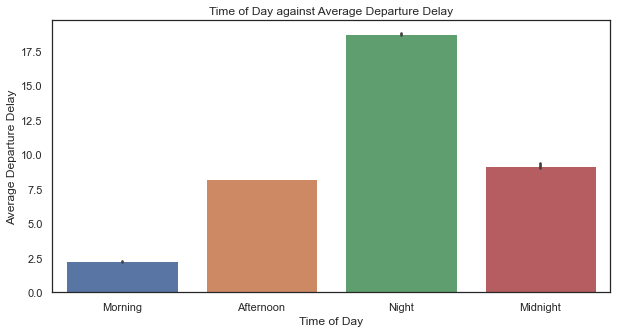

In [24]:
#Question 1: Best time of the day & year to fly [Plot]
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data = alpha, x = 'DepTimeofDay', y = 'DepDelay', order = ['Morning', 'Afternoon', 'Night', 'Midnight'])
ax.set_xlabel("Time of Day")
ax.set_ylabel("Average Departure Delay")
ax.set_title("Time of Day against Average Departure Delay")



In [8]:
#Question 1: Best time of the day & year to fly 
#The fourth quarter is least delayed on average at 34.6 mins
#This is considering when there is departure and arrival delay
c.execute(''' 
         SELECT TimeofYear as TimeofYear, AVG(DepDelay) as Avg_DepDelay
         FROM alpha
         WHERE DepDelay >0 AND ArrDelay >0
         GROUP BY TimeofYear
         ORDER by Avg_DepDelay
         ''')
print(c.fetchone()[0], "is the least delayed quarter on average given that there is arrival and departure delay at", round(c.fetchone()[1],1) ,"mins") 

#The fourth quarter is least delayed on average at 34.6 mins
#This is considering when there is only departure delay
c.execute(''' 
         SELECT TimeofYear as TimeofYear, AVG(DepDelay) as Avg_DepDelay
         FROM alpha
         WHERE DepDelay >0
         GROUP BY TimeofYear
         ORDER by Avg_DepDelay
         ''')
print(c.fetchone()[0], "is the least delayed quarter on average given that there is only departure delay at", round(c.fetchone()[1],1) ,"mins")

#The fourth quarter is least delayed on average at 34.6 mins
#This is when considering the whole population
Best_Time = c.execute(''' 
         SELECT TimeofYear as TimeofYear, AVG(DepDelay) as Avg_DepDelay
         FROM alpha
         GROUP BY TimeofYear
         ORDER by Avg_DepDelay
         ''')
print(c.fetchone()[0], "is the least delayed quarter on average given the whole population at", round(c.fetchone()[1],1) ,"mins")

Fourth Quarter is the least delayed quarter on average given that there is arrival and departure delay at 35.1 mins
Fourth Quarter is the least delayed quarter on average given that there is only departure delay at 29.2 mins
Second Quarter is the least delayed quarter on average given the whole population at 8.2 mins


Apr is the least delayed month, due to weather, on average given the whole population at 0.37 mins


Text(0.5, 1.0, 'Average Weather Delay based on Months')

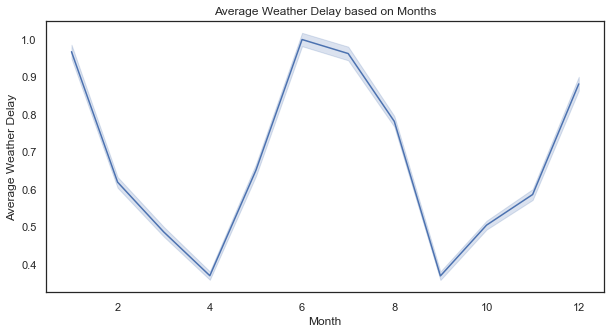

In [21]:
#Question 1: Best time of month to fly based on the weather delays [With plots]
Best_Time = c.execute(''' 
         SELECT Mth as Mth, ROUND(AVG(WeatherDelay),2) as Avg_WeatherDelay
         FROM alpha
         GROUP BY Mth
         ORDER by Avg_WeatherDelay
         ''')
print(c.fetchone()[0], "is the least delayed month, due to weather, on average given the whole population at", round(c.fetchone()[1],2) ,"mins")

#Creating a line plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data = alpha, x = "Month", y = "WeatherDelay")
ax.set_xlabel("Month")
ax.set_ylabel("Average Weather Delay")
ax.set_title("Average Weather Delay based on Months")

Sep is the least delayed month, due to NAS, on average given the whole population at 2.38 mins


Text(0.5, 1.0, 'Average NAS Delay based on Months')

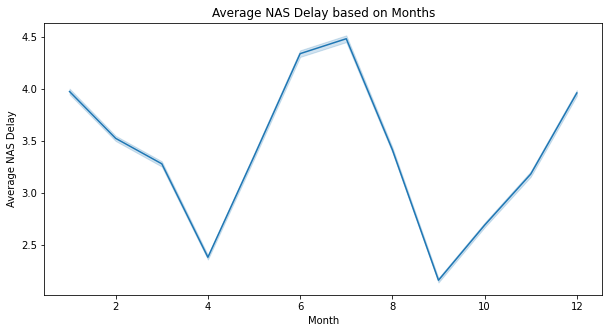

In [8]:
#Question 1: Best time of month to fly based on the NAS delay [With plots]
Best_NAS = c.execute(''' 
         SELECT Mth as Mth, ROUND(AVG(NASDelay),2) as Avg_NASDelay
         FROM alpha
         GROUP BY Mth
         ORDER by Avg_NASDelay
         ''')
print(c.fetchone()[0], "is the least delayed month, due to NAS, on average given the whole population at", round(c.fetchone()[1],2) ,"mins")

#Creating a line plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data = alpha, x = "Month", y = "NASDelay")
ax.set_xlabel("Month")
ax.set_ylabel("Average NAS Delay")
ax.set_title("Average NAS Delay based on Months")

In [10]:
#Question 1: Finding relationship based on Day of Month: Departure & Arrival
#This is given that there is arrival and departure delay
c.execute(''' 
         SELECT DayofMonth as DayofMonth, AVG(DepDelay) as Avg_DepDelay, AVG(ArrDelay) as Avg_ArrDelay,
         Day as Day
         FROM alpha 
         WHERE alpha.ArrDelay >0 AND alpha.DepDelay >0
         GROUP BY DayofMonth
         ORDER by Avg_DepDelay
         ''')
print(c.fetchone()[0], "is the least delayed day of the month at", round(c.fetchone()[1],2), "mins for average arrival delay and", round(c.fetchone()[2],2), "mins for average departure delay")

#This is given that there is only departure delay
c.execute(''' 
         SELECT DayofMonth as DayofMonth, AVG(DepDelay) as Avg_DepDelay, AVG(ArrDelay) as Avg_ArrDelay,
         Day as Day
         FROM alpha 
         WHERE alpha.DepDelay >0
         GROUP BY DayofMonth
         ORDER by Avg_DepDelay
         ''')
print(c.fetchone()[0], "is the least delayed day of the month at", round(c.fetchone()[2],2), "mins for average departure delay")

#This is given that there is only arrival delay
c.execute(''' 
         SELECT DayofMonth as DayofMonth, AVG(DepDelay) as Avg_DepDelay, AVG(ArrDelay) as Avg_ArrDelay,
         Day as Day
         FROM alpha 
         WHERE alpha.ArrDelay >0
         GROUP BY DayofMonth
         ORDER by Avg_DepDelay
         ''')
print(c.fetchone()[0], "is the least delayed day of the month at", round(c.fetchone()[1],2), "mins for average arrival delay")

#This is when considering the whole population
c.execute(''' 
         SELECT DayofMonth as DayofMonth, AVG(DepDelay) as Avg_DepDelay, AVG(ArrDelay) as Avg_ArrDelay,
         Day as Day
         FROM alpha
         GROUP BY DayofMonth
         ORDER by Avg_DepDelay
         ''')
print(c.fetchone()[0], "is the least delayed day of the month at", round(c.fetchone()[1],2), "mins for average arrival delay and", round(c.fetchone()[2],2), "mins for average departure delay")

3 is the least delayed day of the month at 33.89 mins for average arrival delay and 35.92 mins for average departure delay
3 is the least delayed day of the month at 26.65 mins for average departure delay
3 is the least delayed day of the month at 20.21 mins for average arrival delay
3 is the least delayed day of the month at 6.86 mins for average arrival delay and 5.52 mins for average departure delay


Text(0.5, 1.0, 'Average Departure Delay based on Day of Month')

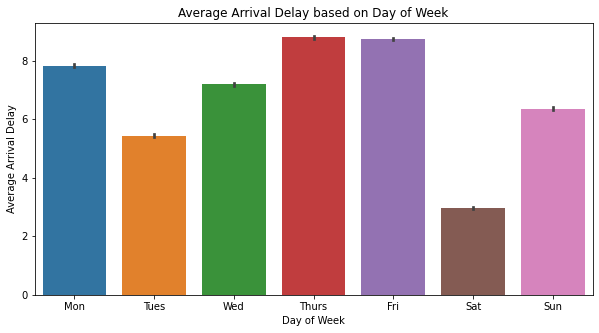

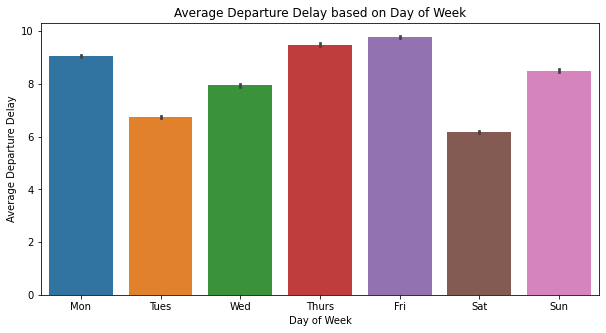

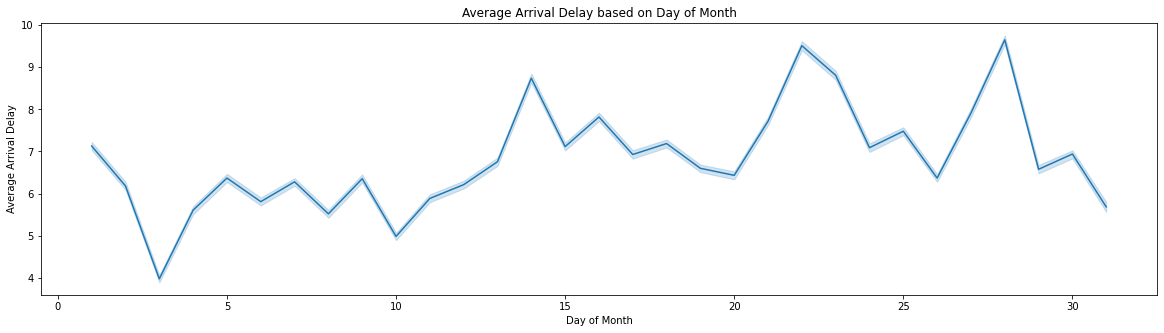

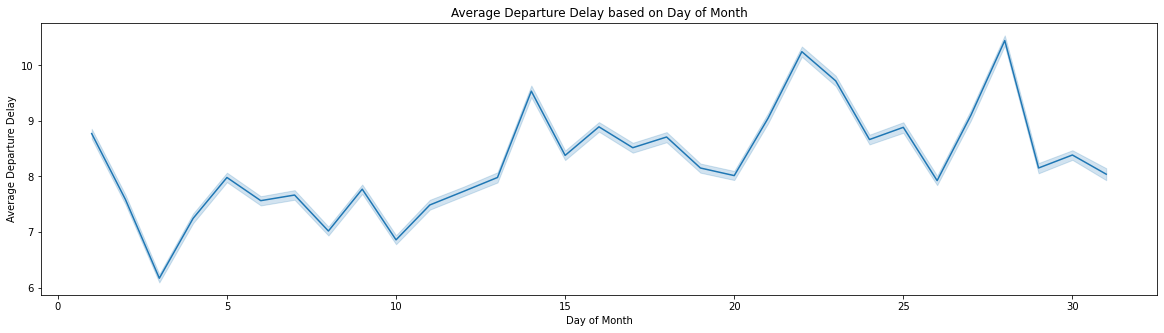

In [11]:
#Question 1: Finding relationship based on Day of Month: Departure & Arrival [Plots]
#Creating a bar plot for day of week and average arrival delay
fig, ax = plt.subplots(figsize=(10, 5))
AD1 = sns.barplot(data = alpha, x = 'Day', y = 'ArrDelay', order = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
ax.set_xlabel("Day of Week")
ax.set_ylabel("Average Arrival Delay")
ax.set_title("Average Arrival Delay based on Day of Week")

#Creating a bar plot for day of week and average departure delay
fig, ax = plt.subplots(figsize=(10, 5))
DD1 = sns.barplot(data = alpha, x = 'Day', y = 'DepDelay', order = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
ax.set_xlabel("Day of Week")
ax.set_ylabel("Average Departure Delay")
ax.set_title("Average Departure Delay based on Day of Week")

#Creating a linedf plot for day of month and average arrival delay
fig, ax = plt.subplots(figsize=(20, 5))
AD2 = sns.lineplot(data = alpha, x = 'DayofMonth', y = 'ArrDelay')
ax.set_xlabel("Day of Month")
ax.set_ylabel("Average Arrival Delay")
ax.set_title("Average Arrival Delay based on Day of Month")

#Creating a line plot for day of month and average departure delay
fig, ax = plt.subplots(figsize=(20, 5))
DD2 = sns.lineplot(data = alpha, x = 'DayofMonth', y = 'DepDelay')
ax.set_xlabel("Day of Month")
ax.set_ylabel("Average Departure Delay")
ax.set_title("Average Departure Delay based on Day of Month")

In [12]:
#Question 1: Finding relationship based on the Month: Arrival & Departure
#This is given that there is arrival and departure delay
c.execute(''' 
         SELECT Mth as Month, AVG(ArrDelay) as Avg_ArrDelay, AVG(DepDelay) as Avg_DepDelay,
         AVG(distance) as Avg_Distance
         FROM alpha
         WHERE alpha.ArrDelay >0 AND alpha.DepDelay >0
         GROUP BY Month
         ORDER by Avg_DepDelay
         ''')
print(c.fetchone()[0], "is the least delayed month at", round(c.fetchone()[1],2), "mins for average arrival delay and", round(c.fetchone()[2],2), "mins for average departure delay")

#This is given that there is only departure delay
c.execute(''' 
         SELECT Mth as Month, AVG(ArrDelay) as Avg_ArrDelay, AVG(DepDelay) as Avg_DepDelay,
         AVG(distance) as Avg_Distance
         FROM alpha
         WHERE alpha.DepDelay >0
         GROUP BY Month
         ORDER by Avg_DepDelay
         ''')
print(c.fetchone()[0], "is the least delayed month at", round(c.fetchone()[2],2), "mins for average departure delay")

#This is when considering the whole population
c.execute(''' 
         SELECT Mth as Month, AVG(ArrDelay) as Avg_ArrDelay, AVG(DepDelay) as Avg_DepDelay,
         AVG(distance) as Avg_Distance
         FROM alpha
         GROUP BY Month
         ORDER by Avg_DepDelay
         ''')
print(c.fetchone()[0], "is the least delayed month at", round(c.fetchone()[1],2), "mins for average arrival delay and", round(c.fetchone()[2],2), "mins for average departure delay")

Apr is the least delayed month at 33.14 mins for average arrival delay and 31.66 mins for average departure delay
Apr is the least delayed month at 25.27 mins for average departure delay
Sep is the least delayed month at 2.66 mins for average arrival delay and 6.03 mins for average departure delay


Text(0.5, 1.0, 'Average Distance based on Month')

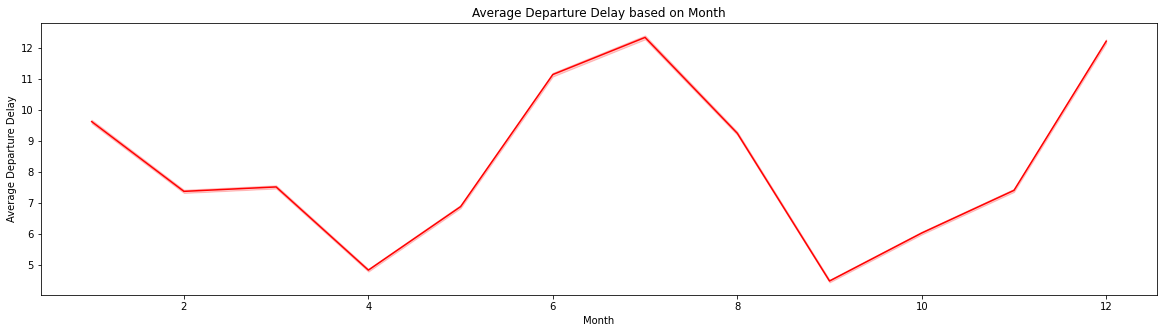

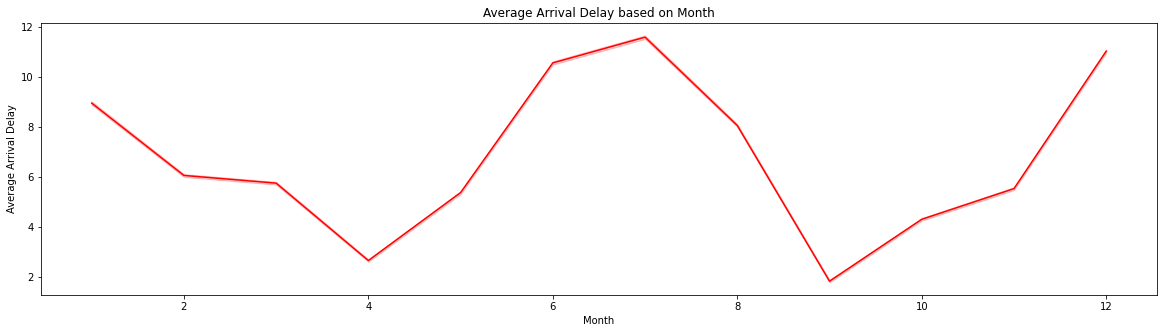

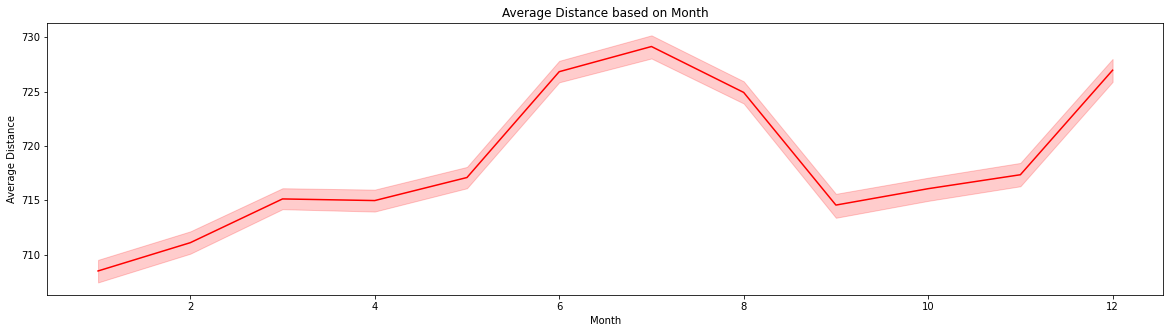

In [13]:
#Question 1: Finding relationship based on the Month: Arrival & Departure [Plot]
#Creating a line plot for month and average departure delay
fig, ax = plt.subplots(figsize=(20, 5))
MDD = sns.lineplot(data = alpha, x = 'Month', y = 'DepDelay', color = 'red')
ax.set_xlabel("Month")
ax.set_ylabel("Average Departure Delay")
ax.set_title("Average Departure Delay based on Month")

#Creating a line plot for month and average arrival delay
fig, ax = plt.subplots(figsize=(20, 5))
MAD = sns.lineplot(data = alpha, x = 'Month', y = 'ArrDelay', color = 'red')
ax.set_xlabel("Month")
ax.set_ylabel("Average Arrival Delay")
ax.set_title("Average Arrival Delay based on Month")

#Creating a line plot for month and average distance
fig, ax = plt.subplots(figsize=(20, 5))
MDist = sns.lineplot(data = alpha, x = 'Month', y = 'Distance', color = 'red')
ax.set_xlabel("Month")
ax.set_ylabel("Average Distance")
ax.set_title("Average Distance based on Month")


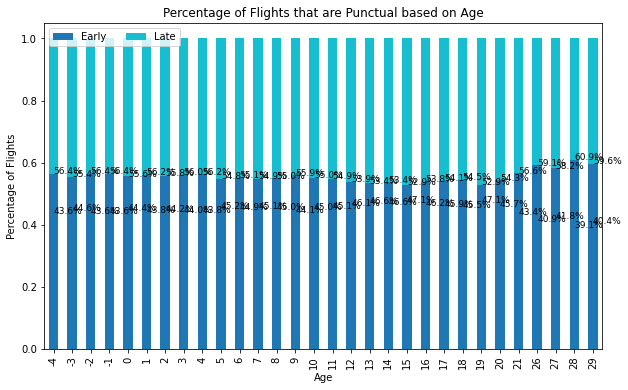

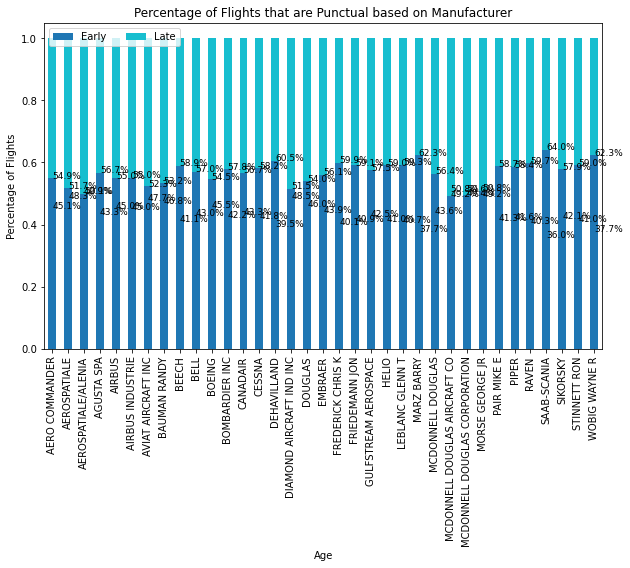

In [7]:
# Question 2: Do older planes suffer more delays?

# Create new column referencing issue date 
planes["issue_year"] = planes["issue_date"].str[-4:] 
total_flights = pd.merge(alpha, planes, how = 'left', left_on = ['TailNum'], right_on = ['tailnum']) # Join alpha and planes
total_flights.issue_year.replace(float('NaN'),'' , inplace=True)
total_flights.issue_year.replace('None','' , inplace=True)
temp = total_flights.drop(total_flights[total_flights['issue_year'] == ""].index, inplace=True)
del temp

#Convert issue_year column to an integer
total_flights['issue_year'] = total_flights['issue_year'].apply(int) 

#Obtain new column based on other columns
total_flights["Age"] = total_flights["Year"] - total_flights["issue_year"] 

#Drawing of a 100% stacked plot with age against punctuality
cross_tab1 = pd.crosstab(index = total_flights['Age'],
                             columns = total_flights['Punctuality'],
                             normalize = "index")

cross_tab1.plot(kind = 'bar', 
               stacked = True, 
               colormap = 'tab10', 
               figsize = (10, 6))

plt.legend(loc = "upper left", ncol = 2)
plt.xlabel("Age")
plt.ylabel("Percentage of Flights")
plt.title("Percentage of Flights that are Punctual based on Age")


for n, x in enumerate([*cross_tab1.index.values]):
    for proportion in cross_tab1.loc[x]:
        plt.text(x = n,
                 y = proportion,
                 s = f'{np.round(proportion * 100, 1)}%', 
                 color = "black",
                 fontsize = 9)

plt.show()

#Plotting a 100% stacked plot with manufacturer against punctuality
cross_tab2 = pd.crosstab(index = total_flights['manufacturer'],
                             columns = total_flights['Punctuality'],
                             normalize = "index")

cross_tab2.plot(kind = 'bar', 
               stacked = True, 
               colormap = 'tab10', 
               figsize = (10, 6))

plt.legend(loc = "upper left", ncol = 2)
plt.xlabel("Age")
plt.ylabel("Percentage of Flights")
plt.title("Percentage of Flights that are Punctual based on Manufacturer")

for n, x in enumerate([*cross_tab2.index.values]):
    for proportion in cross_tab2.loc[x]:
        plt.text(x = n,
                 y = proportion,
                 s = f'{np.round(proportion * 100, 1)}%', 
                 color = "black",
                 fontsize = 9)

plt.show()

In [8]:
#Question 3: How does the number of people flying between different locations change over time?

#Obtain dataframe based on year 2004 while reducing ram required by reducing sample size to the first 10,000 indexes
Avg_no_of_flights_2004 = alpha[alpha['Year'] == 2004]
Avg_no_of_flights_2004 = Avg_no_of_flights_2004[['Dest', 'Year', 'DepTime']] 
Avg_no_of_flights_2004 = Avg_no_of_flights_2004.reset_index(drop = True)
Avg_no_of_flights_2004 = Avg_no_of_flights_2004.loc[:10000]


#Obtain dataframe based on year 2005 while reducing ram required by reducing sample size to the first 10,000 indexes
Avg_no_of_flights_2005 = alpha[alpha['Year'] == 2005]
Avg_no_of_flights_2005 = Avg_no_of_flights_2005[['Dest', 'Year', 'DepTime']]
Avg_no_of_flights_2005 = Avg_no_of_flights_2005.reset_index(drop = True)
Avg_no_of_flights_2005 = Avg_no_of_flights_2005.loc[:10000]

Avg_no_of_flights_2004 = pd.DataFrame(c.execute(''' 
         SELECT Dest as Destination, Year as Year1, COUNT(DepTime) as FrequencyX, SUM(Distance) as Total_DistanceX
         FROM alpha
         WHERE alpha.Year == 2004
         GROUP BY Destination
         ORDER by FrequencyX
         '''), columns = ['Destination', 'Year1', 'FrequencyX', 'Total_DistanceX']
                                     )

Avg_no_of_flights_2005 = pd.DataFrame(c.execute(''' 
         SELECT Dest as Destination, Year as Year2, COUNT(DepTime) as FrequencyY, SUM(Distance) as Total_DistanceY
         FROM alpha
         WHERE alpha.Year == 2005
         GROUP BY Destination
         ORDER by FrequencyY
         '''), columns = ['Destination', 'Year2', 'FrequencyY', 'Total_DistanceY']
                                     )

Avg_no_of_flights = pd.merge(Avg_no_of_flights_2004, Avg_no_of_flights_2005, how = 'left', left_on = ['Destination'], right_on = ['Destination'])
Avg_no_of_flights.dropna()
Avg_no_of_flights = Avg_no_of_flights[Avg_no_of_flights['FrequencyX'] > 30]

#To disable warning from pandas library
pd.options.mode.chained_assignment = None 

#Perform arithmetic calculations to get % values
Avg_no_of_flights['Difference_F'] = Avg_no_of_flights['FrequencyY'] - Avg_no_of_flights['FrequencyX']
Avg_no_of_flights['Percentage_Change'] = Avg_no_of_flights['Difference_F'] / Avg_no_of_flights['FrequencyX'] * 100
print("The change of average number of flights during 2004 and 2005 is", round(Avg_no_of_flights['Percentage_Change'].mean(),2), "%")

Avg_no_of_flights['Avg_DistX'] = Avg_no_of_flights['Total_DistanceX'] / Avg_no_of_flights['FrequencyX']
Avg_no_of_flights['Avg_DistY'] = Avg_no_of_flights['Total_DistanceY'] / Avg_no_of_flights['FrequencyY']
Avg_no_of_flights['Difference_D'] = Avg_no_of_flights['Avg_DistY'] - Avg_no_of_flights['Avg_DistX']
Avg_no_of_flights['Percentage_ChangeD'] = Avg_no_of_flights['Difference_D'] / Avg_no_of_flights['Avg_DistX'] * 100
print("The change of average distance traveled by flights during 2004 and 2005 is", round(Avg_no_of_flights['Percentage_ChangeD'].mean(),2), "%")

For every 0.01 % that average departure delay increases, average arrival delay changes by 0.57 %


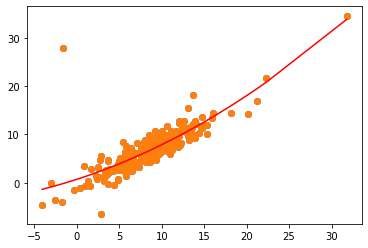

In [16]:
#Question 4: Can you detect cascading failures as delays in one airport create delays in others?

#Using polyfit linear regression to discover how Departure and Arrival delay is correlated.
Airport_Delay = pd.DataFrame(c.execute(''' 
         SELECT Dest as Destination, AVG(DepDelay) as Avg_Departure_Delay, AVG(ArrDelay) as Avg_Arrival_Delay
         FROM alpha
         GROUP BY Destination
         ORDER by Avg_Departure_Delay
         '''), columns = ['Destination', 'Avg_Departure_Delay', 'Avg_Arrival_Delay']
                            )

Airport_Delay = Airport_Delay.dropna()

#Plot a scatter plot with Avg_Departure_Delay being the independent variable
plt.scatter(x = Airport_Delay['Avg_Departure_Delay'], y = Airport_Delay['Avg_Arrival_Delay']);
reg = np.polyfit(Airport_Delay['Avg_Departure_Delay'], Airport_Delay['Avg_Arrival_Delay'], deg = 2)
print("For every", round(reg[0],2),"% that average departure delay increases, average arrival delay changes by", round(reg[1],2), "%")

#Plot with a trendline
trend = np.polyval(reg, Airport_Delay['Avg_Departure_Delay'])
plt.scatter(Airport_Delay['Avg_Departure_Delay'], Airport_Delay['Avg_Arrival_Delay']);
plt.plot(Airport_Delay['Avg_Departure_Delay'], trend, 'r')
plt.show()

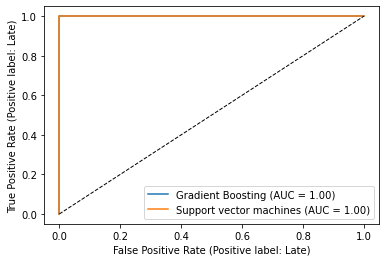

In [36]:
#Question 5: Use the available variables to construct a model that predicts delays.
#Using gradient boosting and SVM to predict cascading delays in question 2

#Reset indexing for dataframe
total_flights.reset_index(drop = True)

#Reduce the size of the dataframe to offset the burden on the ram
total_flights = total_flights.loc[:10000]

#Set the independent variables
variables = total_flights[['Age', 'DepDelay', 'TimeofYear', 'ArrDelay', 'Punctuality']]
X = variables
y = variables[['Punctuality']]

#Set the numerical variables
numerical_features = ['Age', 'DepDelay', 'ArrDelay']

numerical_transformer = Pipeline(steps = [('imputer', SimpleImputer()), ('scaler', StandardScaler())])

#Set the categorical variables
categorical_features = ['TimeofYear']

#Applying SimpleImputer and OneHotEncoder into another pipeline
categorical_transformer = Pipeline(steps = [('imputer', SimpleImputer()), ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

data_transformer = ColumnTransformer(
    transformers = [
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)]) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.6,random_state = 2)

#Setting the parameters
param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
    'data_transformer__categorical__imputer__strategy': ['constant','most_frequent']
}

#Perform gradient boosting - ML
pipe_gdb = Pipeline(steps = [('data_transformer', data_transformer),
       ('pipe_gdb', GradientBoostingClassifier(random_state = 2))])

grid_gdb = GridSearchCV(pipe_gdb, param_grid = param_grid)
grid_gdb.fit(X_train, y_train);

#Perform support vector machine - ML
pipe_svm = Pipeline(steps = [('data_transformer', data_transformer),
                           ('pipe_svm',  LinearSVC(random_state = 2, max_iter = 10000, tol = 0.15))])
grid_svm = GridSearchCV(pipe_svm, param_grid = param_grid)
grid_svm.fit(X_train, y_train);

#Drawing of 2 receiver operating characteristic plot
ax = plt.gca()
plot_roc_curve(grid_gdb, X_test, y_test, ax = ax, name = 'Gradient Boosting')
plot_roc_curve(grid_svm, X_test, y_test, ax = ax, name = 'Support vector machines')
plt.plot([0, 1], [0, 1], color = 'black', lw = 1, linestyle = '--')
plt.show()